Early and precise cancer detection has the potential to save lives and reduce the intensity of care required.  This dataset of 220,025 images of metastatic cancer and healthy cells is analyzed to predict which images contain cancerous cells.  The original data is from the two sources below.  The model will utilize convolutional layers that pass success stacks of filters over the data to pick out features.  Each filter picks out different features that are then pooled and fed into a small neural net to make the final prediction.   
   
[1] B. S. Veeling, J. Linmans, J. Winkens, T. Cohen, M. Welling. "Rotation Equivariant CNNs for Digital Pathology". arXiv:1806.03962

[2] Ehteshami Bejnordi et al. Diagnostic Assessment of Deep Learning Algorithms for Detection of Lymph Node Metastases in Women With Breast Cancer. JAMA: The Journal of the American Medical Association, 318(22), 2199–2210. doi:jama.2017.14585

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

The list of training files and labels is read in from the csv provided.  We see there are 220,025 images of which 130,908 (59.5%) are for the negative class.

In [2]:
df = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
print(df.id.unique().shape, df.shape)
df=df.set_index('id')
df.head()

(220025,) (220025, 2)


,label
id,
f38a6374c348f90b587e046aac6079959adf3835,0
c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
755db6279dae599ebb4d39a9123cce439965282d,0
bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
068aba587a4950175d04c680d38943fd488d6a9d,0


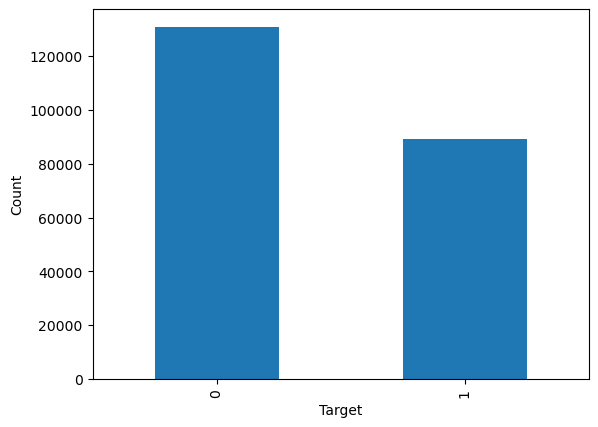

0    0.594969
1    0.405031
Name: label, dtype: float64


In [3]:
df.label.value_counts().plot.bar()
plt.xlabel('Target')
plt.ylabel('Count')
plt.show()
print(df.label.value_counts(normalize=True))

The first image is read in and displayed.

(96, 96)


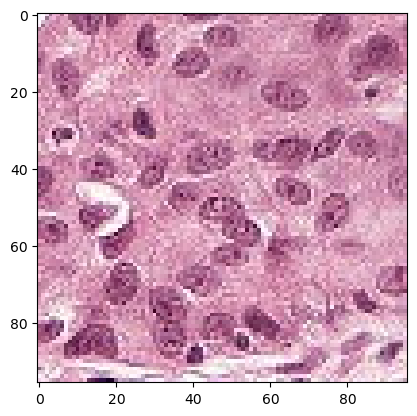

In [4]:
train_dir = '../input/histopathologic-cancer-detection/train'
training_files = os.listdir(train_dir)
with Image.open(train_dir + '/'+ training_files[0]) as im:
    print(im.size)
    plt.imshow(im)

The image id's are appended with the file type to get a directory path.

In [5]:
df.label = df.label.astype(str)
df['file_name'] = df.index + '.tif'
df.head()

,label,file_name
id,,
f38a6374c348f90b587e046aac6079959adf3835,0,f38a6374c348f90b587e046aac6079959adf3835.tif
c18f2d887b7ae4f6742ee445113fa1aef383ed77,1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif
755db6279dae599ebb4d39a9123cce439965282d,0,755db6279dae599ebb4d39a9123cce439965282d.tif
bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif
068aba587a4950175d04c680d38943fd488d6a9d,0,068aba587a4950175d04c680d38943fd488d6a9d.tif


Image data is read in using the ImageDataGenerator class with 20% held out for validation.

In [6]:
datagen = ImageDataGenerator(rescale=1./255., validation_split=0.2)
train_ds = datagen.flow_from_dataframe(
    dataframe=df,
    directory=os.path.join('../input/histopathologic-cancer-detection/train'),
    x_col="file_name",
    y_col="label",
    subset="training",
    batch_size=32,
    seed=156,
    class_mode="binary",
    target_size=(64,64))  

Found 176020 validated image filenames belonging to 2 classes.


In [7]:
val_ds = datagen.flow_from_dataframe(
    dataframe=df,
    directory=os.path.join('../input/histopathologic-cancer-detection/train'),
    x_col="file_name",
    y_col="label",
    subset="validation",
    batch_size=32,
    seed=156,
    class_mode="binary",
    target_size=(64,64))  

Found 44005 validated image filenames belonging to 2 classes.


In [8]:
def plot_model(history):
    acc = history.history['Accuracy']
    val_acc = history.history['val_Accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(history.history['Accuracy']))

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

Quite a few models were tested.  The one here uses three convolutional layers with maxpooling after layers 2 and 3 followed by a relatively small neural net with 16 nodes.  The data is trained for 6 epochs, after that overfitting occurs and increases the already long run time.  Experimented with more or less nodes in each layer, added convolutional layers, and 1x1 convolutional layers.  Adding the 1x1 layers in particular decreased model accuracy.

In [9]:
model = Sequential()
model.add(layers.Conv2D(16,3, activation='relu', input_shape=(64,64, 3)))
model.add(layers.Conv2D(32,3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(32,3, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation = 'relu'))
model.add(layers.Dense(1, activation = 'sigmoid'))

model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['Accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        4640      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 6272)              0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/6
5501/5501 [==============================] - 1426s 257ms/step - loss: 0.4672 - Accuracy: 0.7921 - val_loss: 0.3942 - val_Accuracy: 0.8321
Epoch 2/6
5501/5501 [==============================] - 565s 103ms/step - loss: 0.3708 - Accuracy: 0.8427 - val_loss: 0.3324 - val_Accuracy: 0.8612
Epoch 3/6
5501/5501 [==============================] - 504s 92ms/step - loss: 0.3288 - Accuracy: 0.8609 - val_loss: 0.3327 - val_Accuracy: 0.8601
Epoch 4/6
5501/5501 [==============================] - 479s 87ms/step - loss: 0.3055 - Accuracy: 0.8718 - val_loss: 0.2957 - val_Accuracy: 0.8763
Epoch 5/6
5501/5501 [==============================] - 482s 88ms/step - loss: 0.2877 - Accuracy: 0.8793 - val_loss: 0.2958 - val_Accuracy: 0.8774
Epoch 6/6
5501/5501 [==============================] - 486s 88ms/step - loss: 0.2715 - Accuracy: 0.8866 - val_loss: 0.2844 - val_Accuracy: 0.8815


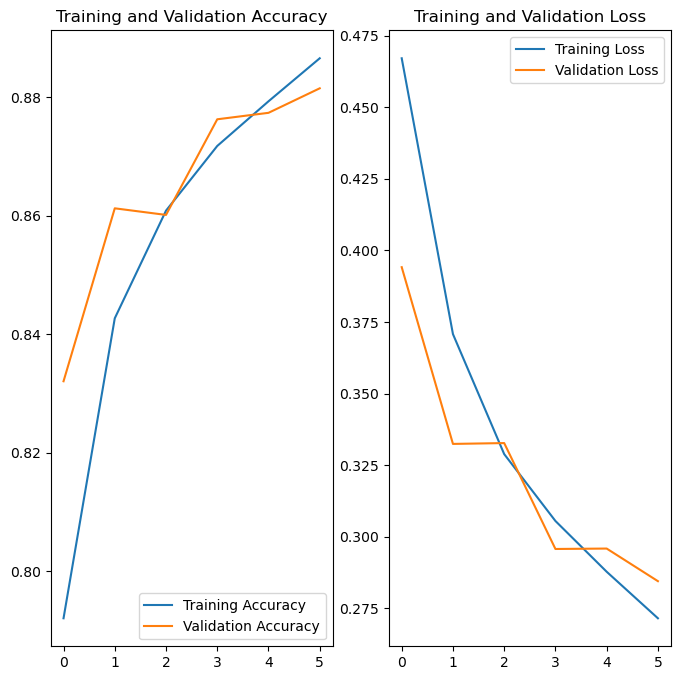

In [10]:
model_history = model.fit_generator(train_ds, validation_data = val_ds, epochs=6, steps_per_epoch=None)
plot_model(model_history)

The second model tested had the same architecture, with less convolution channels and more dense layers above to see which was more effective.  The neural net size was chosen to have approximately the same number of parameters as the first model.  After 3 or 4 epochs overfitting was seen.

In [11]:
model2 = Sequential()
model2.add(layers.Conv2D(16,3, activation='relu', input_shape=(64,64, 3)))
model2.add(layers.Conv2D(16,3, activation='relu'))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Conv2D(16,3, activation='relu'))
model2.add(layers.MaxPooling2D(pool_size=(2,2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(35, activation = 'relu'))
model2.add(layers.Dense(35, activation = 'relu'))
model2.add(layers.Dense(1, activation = 'sigmoid'))

model2.compile(optimizer='adam', loss = 'binary_crossentropy', metrics=['Accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 16)        448       
                                                                 
 conv2d_4 (Conv2D)           (None, 60, 60, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 14, 14, 16)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 3136)             

Epoch 1/6


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


5501/5501 [==============================] - 492s 89ms/step - loss: 0.4140 - Accuracy: 0.8121 - val_loss: 0.3689 - val_Accuracy: 0.8368
Epoch 2/6
5501/5501 [==============================] - 469s 85ms/step - loss: 0.3382 - Accuracy: 0.8538 - val_loss: 0.3346 - val_Accuracy: 0.8544
Epoch 3/6
5501/5501 [==============================] - 452s 82ms/step - loss: 0.3137 - Accuracy: 0.8650 - val_loss: 0.3238 - val_Accuracy: 0.8626
Epoch 4/6
5501/5501 [==============================] - 463s 84ms/step - loss: 0.2946 - Accuracy: 0.8746 - val_loss: 0.3387 - val_Accuracy: 0.8556
Epoch 5/6
5501/5501 [==============================] - 469s 85ms/step - loss: 0.2773 - Accuracy: 0.8828 - val_loss: 0.2947 - val_Accuracy: 0.8762
Epoch 6/6
5501/5501 [==============================] - 474s 86ms/step - loss: 0.2637 - Accuracy: 0.8894 - val_loss: 0.3069 - val_Accuracy: 0.8706


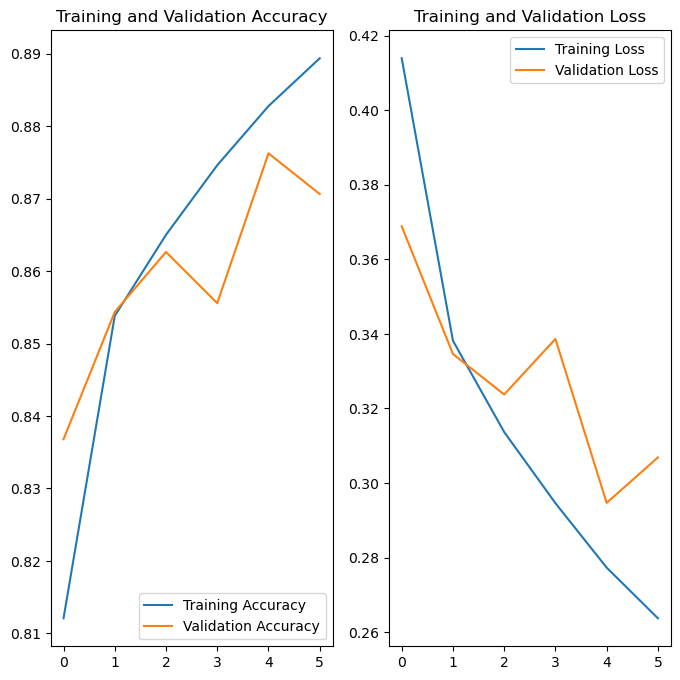

In [12]:
model2_history = model2.fit_generator(train_ds, validation_data = val_ds, epochs=6, steps_per_epoch=None)
plot_model(model2_history)

Plotting both model's validation set accuracy we see additional convolutional channels outperforms additional neural nodes.

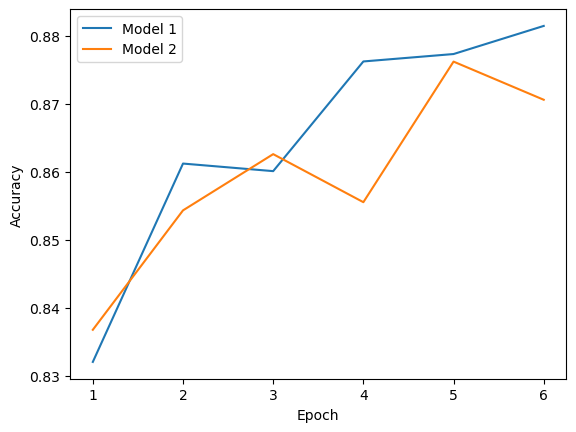

In [13]:
n = range(len(model_history.history['Accuracy']))
plt.plot(range(1,7), model_history.history['val_Accuracy'], label='Model 1')
plt.plot(range(1,7), model2_history.history['val_Accuracy'], label='Model 2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
submission_dir = '../input/histopathologic-cancer-detection/test'
submission_files = os.listdir(submission_dir)
submission_df=pd.DataFrame({'id':submission_files})
submission_df['label'] = 1
submission_df.shape

(57458, 2)

In [15]:
submission_ds = datagen.flow_from_dataframe(
    dataframe=submission_df,
    directory=os.path.join('../input/histopathologic-cancer-detection/test'),
    x_col="id",
    batch_size=32,
    class_mode=None,
    target_size=(64,64))

Found 57458 validated image filenames.


In [16]:
x = model.predict_generator(submission_ds)
submission_df['label'] = x
submission_df['label'] = submission_df.label.round(0).astype(int)
submission_df.id = submission_df.id.apply(lambda x: x.split('.')[0])
submission_df.to_csv('submission.csv', index=False)
submission_df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,0
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,0


Conclusion:   
Adding convolutional layers was able to outperform neural nets with similar number of parameters.  Really struggled with the model pipelines for image data and future work would look at improving the pipeline architecture.  The competition docs mention that the cancer is centered and 32x32 pixels, but wasn't sure how to crop.  The image generator class also has the ability to rotate the images to improve model robustness.